# Random Forest Hyperparameter Tuning

Neben XGBoost wurde auch Random Forest als eins der geeigneten Modelle identifiziert. In diesem Notebook wird nun das Random Forest-Modell optimiert.

In [1]:
from helper import *

df = load_merged_data(only_standard_refuelling=True)

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

Im nächsten Schritt wird ein Random Forest-Modell trainiert. Dazu werden verschiedene Hyperparameter-Kombinationen ausprobiert und die beste Kombination ausgewählt.

Dabei wird dasselbe Vorgehen wie bei XGBoost verwendet. Daher wird `RandomizedSearchCV`, `SkipFirstTimeSeriesSplit` und `MAPE` verwendet.   

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

X_train, y_train = split_xy(df, input_columns)

random_forest_model = RandomForestRegressor()

param_distributions = {
    'n_estimators': randint(50, 200),
    'max_features': [None, 1.0, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

cv = SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2)

hyperparameter_search = RandomizedSearchCV(
    estimator=random_forest_model,
    param_distributions=param_distributions,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    verbose=2,
    n_jobs=1,
    return_train_score=True,
    error_score='raise',
    n_iter=30
)

hyperparameter_search.fit(X_train[::500], y_train[::500])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=96; total time=  12.6s
[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=96; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=96; total time=  21.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=58; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=58; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=58; total time=   1.9s
[CV] END bootstrap=False, max_depth=30, max_features=1.0, min_samples_leaf=4, min_samples_split=8, n_estimators=165; total tim

RandomizedSearchCV(cv=SkipFirstTimeSeriesSplit(gap=0, max_train_size=None, n_skip_splits=2,
             n_splits=5, test_size=None),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=30, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': [None, 1.0, 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1370dc110>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1370d3ad0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1420b9ad0>},
                   return_train_score=True,
                   scoring='neg_mean_absolute_percentage_error', verbose=2)

Nach dem Training können die Parameterkombination nach dem besten `mean_test_score` sortiert werden, sodass die besten Parameter gefunden werden können.

In [5]:
result_df = pd.DataFrame(hyperparameter_search.cv_results_)
result_df = result_df[['params', 'mean_fit_time', 'mean_test_score', 'mean_train_score']]

# Umwandeln von negativen Werten in positive Werte
result_df['mean_test_score'] = -result_df['mean_test_score']
result_df['mean_train_score'] = -result_df['mean_train_score']

# Sortieren nach mean_test_score
result_df = result_df.sort_values(by='mean_test_score', ascending=True)

result_df

,params,mean_fit_time,mean_test_score,mean_train_score
12,"{'bootstrap': True, 'max_depth': None, 'max_fe...",34.052257,0.248068,0.083778
27,"{'bootstrap': True, 'max_depth': None, 'max_fe...",39.383557,0.248464,0.083962
13,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",27.058708,0.248949,0.084463
0,"{'bootstrap': True, 'max_depth': None, 'max_fe...",17.231040,0.249504,0.096383
23,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",35.559658,0.249707,0.073903
9,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",22.671149,0.250230,0.086382
5,"{'bootstrap': True, 'max_depth': None, 'max_fe...",16.304681,0.250676,0.096467
16,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",15.986956,0.251190,0.075979
26,"{'bootstrap': True, 'max_depth': None, 'max_fe...",36.471922,0.252048,0.073116
29,"{'bootstrap': False, 'max_depth': 20, 'max_fea...",6.257731,0.271710,0.049160


In [6]:
# print best parameters
hyperparameter_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 185}

# Finales Model

Mithilfe des Hyperparameter Tunings wurden die besten Parameter für das Modell gefunden.
Final kann nun dieses Modell noch einmal trainiert werden.

In [7]:
model_params = hyperparameter_search.best_params_

randomForestTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: RandomForestRegressor(**model_params))
randomForestTrainer.cross_validation()

Finished fold
    Train Duration: 169.42343306541443 seconds
    Train Size: 44371
    MAPE: 0.21982528031019188
    MSE: 18.42866915917807
    RSME: 4.292862583309425
Finished fold
    Train Duration: 206.68262600898743 seconds
    Train Size: 59161
    MAPE: 0.24951342218032366
    MSE: 201.5245395541598
    RSME: 14.19593390919244
Finished fold
    Train Duration: 256.3129782676697 seconds
    Train Size: 73951
    MAPE: 0.2465358674931755
    MSE: 69.99860482361154
    RSME: 8.366516887188572
Average MAPE: 0.23862485666123034
Average MSE: 96.65060451231648
Average RSME: 9.831103931518397


0.23862485666123034

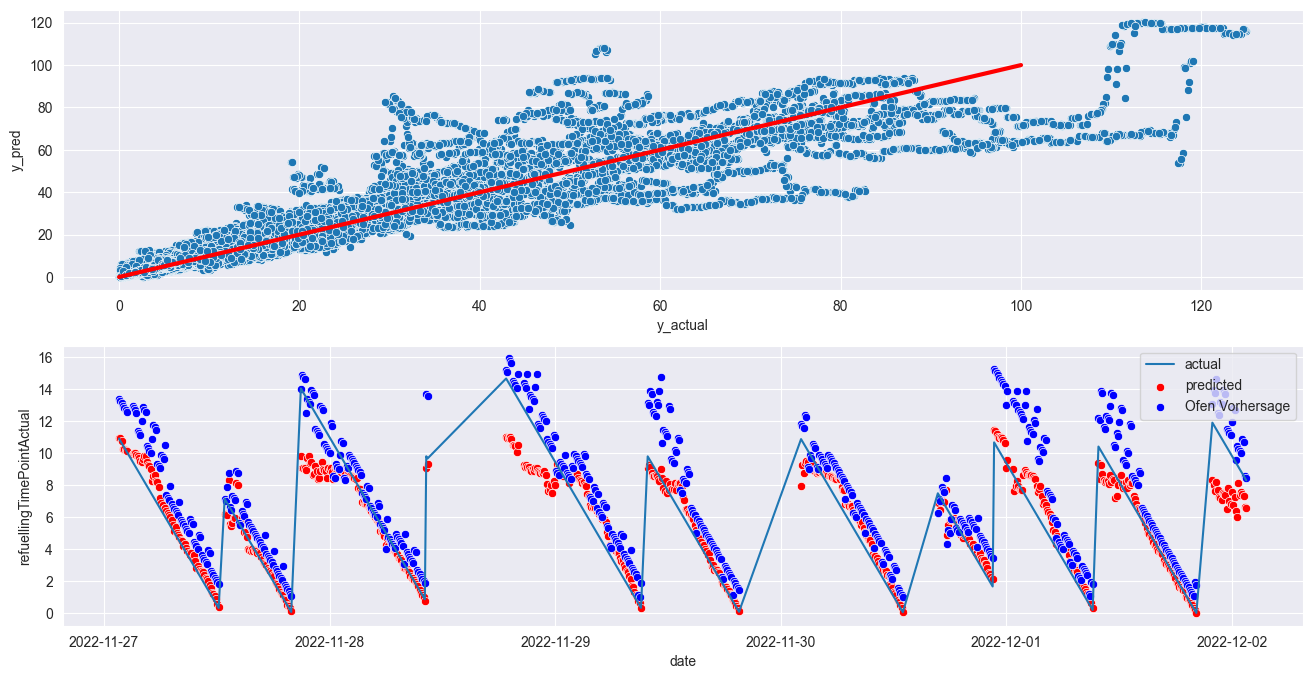

In [8]:
randomForestTrainer.visualize_split()

In [9]:
randomForestTrainer.train()

RandomForestRegressor(max_features=None, min_samples_leaf=3,
                      min_samples_split=5, n_estimators=185)

## Feature Importance

Auch beim Random Forest Modell kann die Feature Importance betrachtet werden. Dabei ist zu beachten, dass die Werte nicht direkt vergleichbar sind, da die Skalierung der Feature-Bewertung unterschiedlich ist. Um den Fokus der Modelle vergleichbar zu machen, ist es jedoch ausreichend.

Insgesamt kann man feststellen, dass dieselben Features eine ähnlich hohe Relevanz für die Vorhersage in den beiden Modellen aufweisen.  

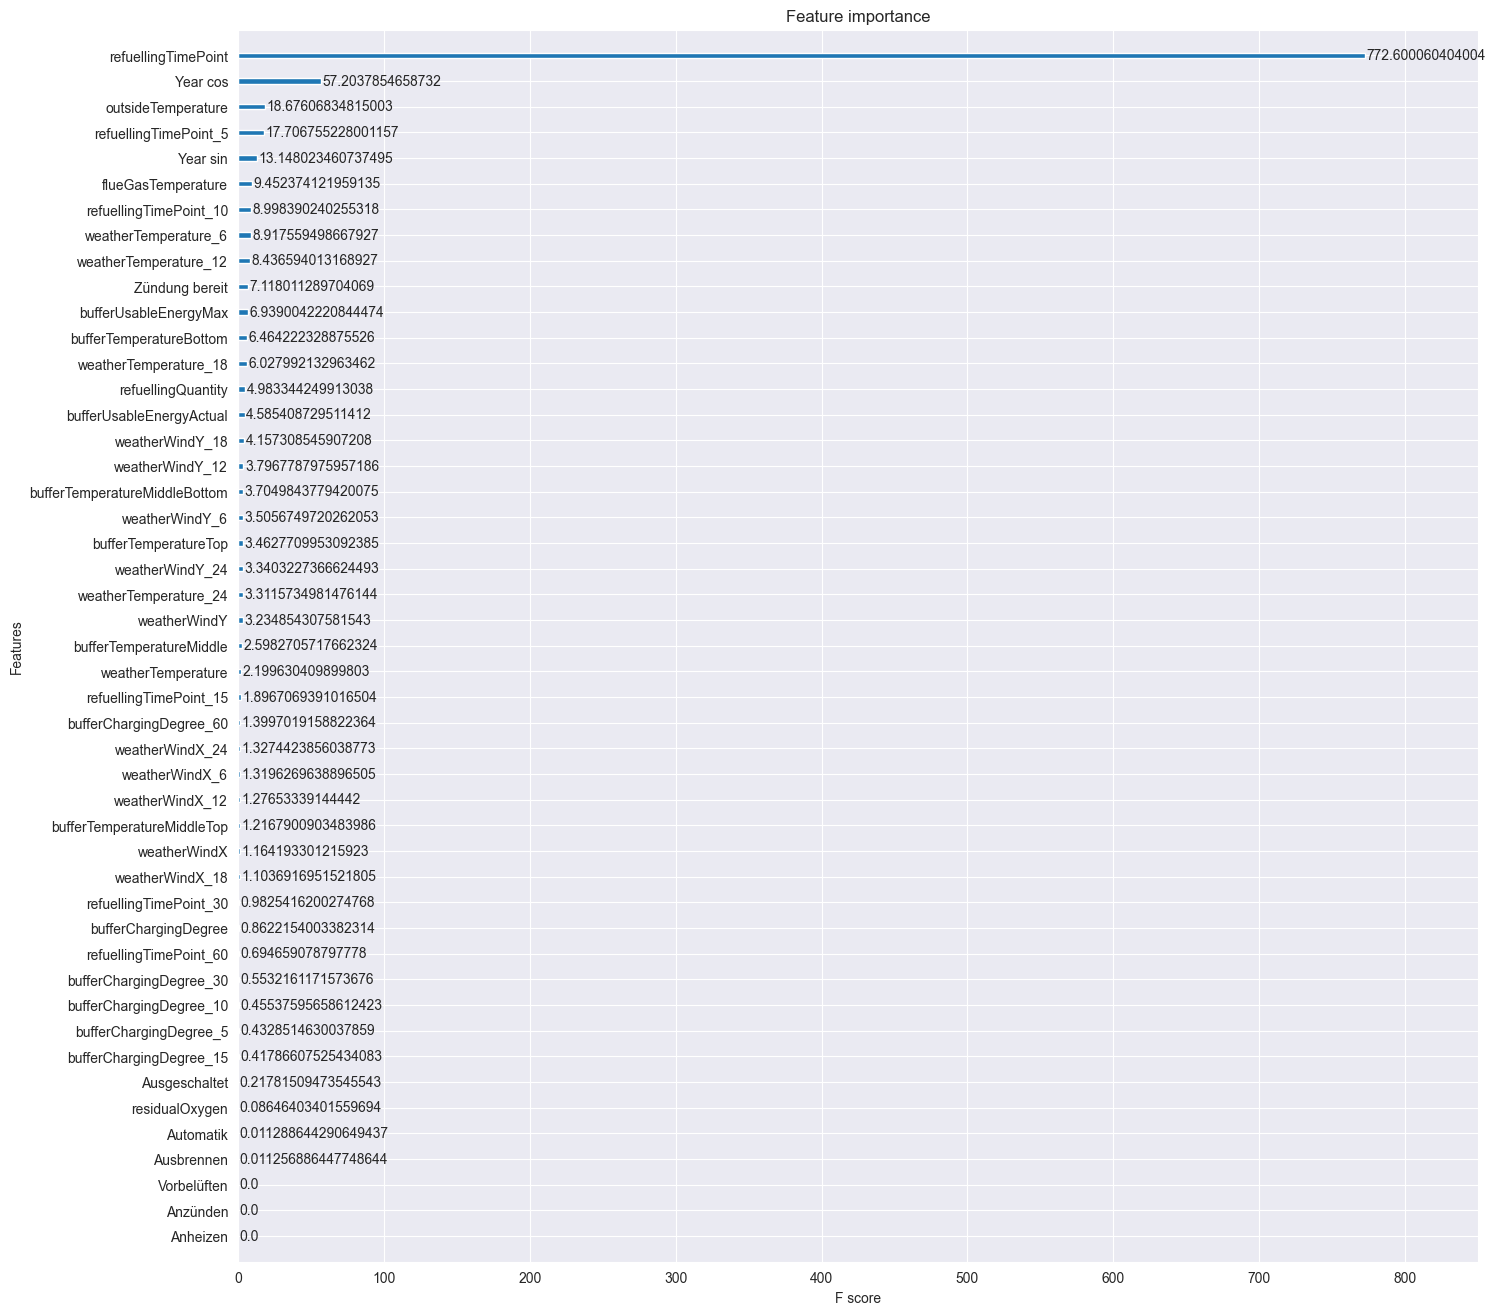

In [10]:
import xgboost as xgb

# combine input columns with feature importance into a dictionary
importance = dict(zip(input_columns, randomForestTrainer.model.feature_importances_ * 1000))

xgb.plot_importance(importance)
plt.gcf().set_size_inches(16, 16)